In [1]:
from Funcs.Utility import *

In [2]:
p = os.path.join(PATH_INTERMEDIATE, 'calorie_count_binary_personal-15min.pkl')
X, y, groups, t, datetimes = load(p)

In [3]:
#Divide the features into different categories
feat_current = X.loc[:,[('#VAL' in str(x)) or ('ESM#LastLabel' in str(x)) for x in X.keys()]]  
feat_dsc = X.loc[:,[('#DSC' in str(x))  for x in X.keys()]]  
feat_yesterday = X.loc[:,[('Yesterday' in str(x))  for x in X.keys()]]  
feat_today = X.loc[:,[('Today' in str(x))  for x in X.keys()]]  
feat_sleep = X.loc[:,[('Sleep' in str(x))  for x in X.keys()]]  
feat_time = X.loc[:,[('Time' in str(x))  for x in X.keys()]]  
feat_pif = X.loc[:,[('PIF' in str(x))  for x in X.keys()]]  
feat_ImmediatePast = X.loc[:,[('ImmediatePast_15' in str(x))  for x in X.keys()]]
#Divide the time window features into sensor/past stress label
feat_current_sensor = X.loc[:,[('#VAL' in str(x))  for x in X.keys()]]  
feat_current_ESM = X.loc[:,[('ESM#LastLabel' in str(x)) for x in X.keys()]]  
feat_ImmediatePast_sensor = feat_ImmediatePast.loc[:,[('ESM' not in str(x)) for x in feat_ImmediatePast.keys()]]  
feat_ImmediatePast_ESM = feat_ImmediatePast.loc[:,[('ESM'  in str(x)) for x in feat_ImmediatePast.keys()]]  
feat_today_sensor = feat_today.loc[:,[('ESM' not in str(x))  for x in feat_today.keys()]]  
feat_today_ESM = feat_today.loc[:,[('ESM'  in str(x)) for x in feat_today.keys()]]  
feat_yesterday_sensor = feat_yesterday.loc[:,[('ESM' not in str(x)) for x in feat_yesterday.keys()]]  
feat_yesterday_ESM = feat_yesterday.loc[:,[('ESM'  in str(x)) for x in feat_yesterday.keys()]]

In [4]:
feat_baseline = pd.concat([ feat_time,feat_dsc,feat_current_sensor, feat_ImmediatePast_sensor],axis=1)
feat_final = pd.concat([feat_baseline  ], axis=1)
# # Fill NaN values with zeros
feat_final = feat_final.fillna(0)
X = feat_final
cats = X.columns[X.dtypes == bool]

In [5]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, classification_report

In [6]:
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

logo = LeaveOneGroupOut()
user_auc_scores = []

for train_index, test_index in logo.split(X, y, groups=groups):
    # Splitting the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]  # Use standard indexing
    group_test = groups[test_index]  # Use standard indexing

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize the Logistic Regression model
    lr_model = LogisticRegression(
        random_state=42,
        max_iter=1000,
        solver='lbfgs'
    )

    # Train the model
    lr_model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

    # Calculate AUC
    try:
        auc = roc_auc_score(y_test, y_pred_proba)
        print(f"User {group_test[0]} AUC: {auc}")
    except ValueError:
        auc = 0
        print(f"User {group_test[0]} AUC: Unable to calculate AUC due to single class in y_test")

    # Store the PID and its AUC score
    user_auc_scores.append((group_test[0], auc))

# Convert the results into a DataFrame to make sorting easier
user_auc_df = pd.DataFrame(user_auc_scores, columns=['PID', 'AUC'])

# IQR Method to find outliers
Q1 = user_auc_df['AUC'].quantile(0.25)
Q3 = user_auc_df['AUC'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower bound for outliers
lower_bound = Q1 - 1.5 * IQR

# Identify users with AUCs below the lower bound
lowest_performing_users = user_auc_df[user_auc_df['AUC'] < lower_bound]

# Display the lowest-performing users
print("Lowest performing users based on IQR method:")
print(lowest_performing_users)

User P001 AUC: 0.6898537882144439
User P002 AUC: 0.7496590687706994
User P003 AUC: 0.7706243032329989
User P007 AUC: 0.7553214133673903
User P008 AUC: 0.7757253384912959
User P009 AUC: 0.6522058823529412
User P010 AUC: 0.8483389504092442
User P011 AUC: 0.7784397163120568
User P013 AUC: 0.7288109756097562
User P014 AUC: 0.6538770053475936
User P015 AUC: 0.7624694802929892
User P016 AUC: 0.8279532163742691
User P018 AUC: 0.6877072968490877
User P019 AUC: 0.8376807676713068
User P020 AUC: 0.6763131690316156
User P021 AUC: 0.6296203587818107
User P022 AUC: 0.6588628762541806
User P023 AUC: 0.7686150409530901
User P024 AUC: 0.7881656804733729
User P025 AUC: 0.8010752688172043
User P026 AUC: 0.9042409203699526
User P027 AUC: 0.7776315789473685
User P028 AUC: 0.7835648148148149
User P029 AUC: 0.6933200619332005
User P030 AUC: 0.728738236319275
User P033 AUC: 0.7027027027027027
User P034 AUC: 0.7802051282051282
User P035 AUC: 0.7359726836471023
User P037 AUC: 0.7624464831804282
User P038 AUC: 

In [30]:
# Define the lower bound for outliers
lower_bound = Q1 - 1.2 * IQR

# Identify users with AUCs below the lower bound
lowest_performing_users = user_auc_df[user_auc_df['AUC'] < lower_bound]

# Display the lowest-performing users
print("Lowest performing users based on IQR method:")
print(lowest_performing_users) 

Lowest performing users based on IQR method:
      PID       AUC
15   P021  0.629620
32   P042  0.622348
64   P079  0.522934
80   P101  0.608349
84   P105  0.443630
96   P121  0.626231
102  P127  0.586841


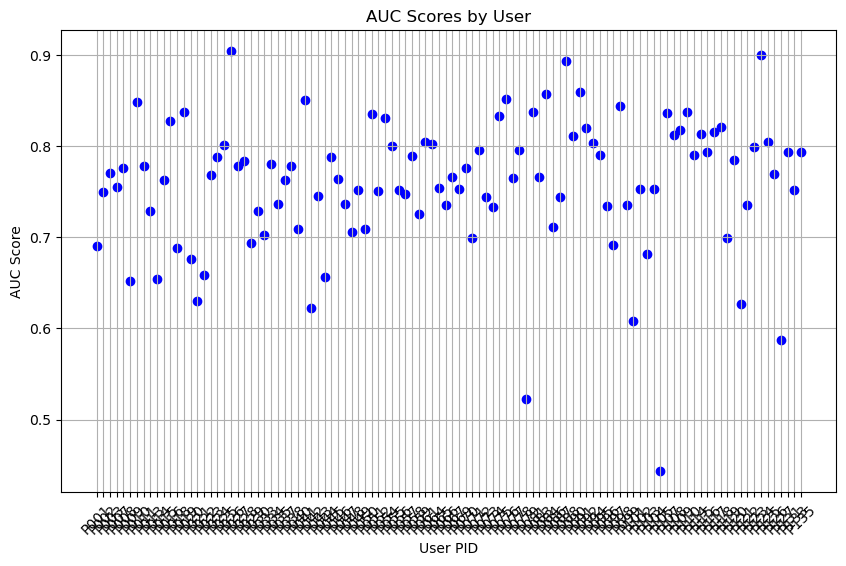

In [31]:
import matplotlib.pyplot as plt

pids, auc_scores = zip(*user_auc_scores)
plt.figure(figsize=(10, 6))
plt.scatter(pids, auc_scores, color='blue')

# Add labels and title
plt.xlabel('User PID')
plt.ylabel('AUC Score')
plt.title('AUC Scores by User')

# Optionally, add a grid for better readability
plt.grid(True)

# Show the plot
plt.xticks(rotation=45)  
plt.show()

In [32]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming the sorted_user_auc_df contains the sorted PIDs with their AUC
# lowest_performing_pids = sorted_user_auc_df['PID'].head(5).values

# # Create a DataFrame for the low-performing and high-performing users using the groups array
# X_low = X[np.isin(groups, lowest_performing_pids)]
# X_high = X[~np.isin(groups, lowest_performing_pids)]

# # Function to compare trends for each feature
# def analyze_feature_trends(cn, X_low, X_high):
#     for feature in cn:
#         print(f"\nAnalyzing Feature: {feature}")
        
#         # Check if the feature is in X
#         if feature not in X.columns:
#             print(f"Feature {feature} not found in dataset!")
#             continue
        
#         # Separate the feature values for low and high-performing users
#         low_vals = X_low[feature]
#         high_vals = X_high[feature]

#         # If the feature is numeric, compare means
#         if np.issubdtype(low_vals.dtype, np.number):
#             low_mean = low_vals.mean()
#             high_mean = high_vals.mean()
#             print(f"Low-performing Mean: {low_mean}, High-performing Mean: {high_mean}")
            
#             # Plot the distribution for both
#             plt.figure(figsize=(10, 6))
#             plt.hist(low_vals, bins=30, alpha=0.5, label='Low-performing', color='red')
#             plt.hist(high_vals, bins=30, alpha=0.5, label='High-performing', color='blue')
#             plt.title(f'Distribution of {feature}')
#             plt.legend()
#             plt.show()
        
#         # If the feature is categorical, compare value counts
#         else:
#             low_counts = low_vals.value_counts(normalize=True)
#             high_counts = high_vals.value_counts(normalize=True)
#             comparison = pd.DataFrame({'Low-performing': low_counts, 'High-performing': high_counts}).fillna(0)
#             print(comparison)
            
#             # Plot the comparison
#             comparison.plot(kind='bar', figsize=(10, 6), title=f'{feature} Comparison')
#             plt.show()

# # Apply the analysis to the feature list
# analyze_feature_trends(cn, X_low, X_high)


In [33]:
!pip install slicer

correlation

In [34]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Assuming the sorted_user_auc_df contains the sorted PIDs with their AUC
lowest_performing_pids = lowest_performing_users['PID']

# Convert 'groups' and 'y' to pandas Series if not already
if not isinstance(groups, pd.Series):
    groups = pd.Series(groups)
if not isinstance(y, pd.Series):
    y = pd.Series(y)

# Create DataFrames for the low-performing and high-performing users using the groups Series
X_low = X[groups.isin(lowest_performing_pids)]
X_high = X[~groups.isin(lowest_performing_pids)]

y_low = y[groups.isin(lowest_performing_pids)]
y_high = y[~groups.isin(lowest_performing_pids)]

# For low-performing users
scaler_low = StandardScaler()
X_low_scaled = scaler_low.fit_transform(X_low)

# For high-performing users
scaler_high = StandardScaler()
X_high_scaled = scaler_high.fit_transform(X_high)

# Train the model for low-performing users
print("Training Logistic Regression for low-performing users...")
lr_model_low = LogisticRegression(random_state=42, max_iter=1000)
lr_model_low.fit(X_low_scaled, y_low)

# Train the model for high-performing users
print("Training Logistic Regression for high-performing users...")
lr_model_high = LogisticRegression(random_state=42, max_iter=1000)
lr_model_high.fit(X_high_scaled, y_high)

# Initialize the SHAP explainer for both models
explainer_low = shap.LinearExplainer(lr_model_low, X_low_scaled)
explainer_high = shap.LinearExplainer(lr_model_high, X_high_scaled)

# Calculate SHAP values for both groups
shap_values_low = explainer_low.shap_values(X_low_scaled)
shap_values_high = explainer_high.shap_values(X_high_scaled)

# Calculate mean absolute SHAP values for feature importance
importance_low = np.abs(shap_values_low).mean(axis=0)
importance_high = np.abs(shap_values_high).mean(axis=0)

# Ensure arrays are 1-dimensional
print("Importance_low shape:", importance_low.shape)
print("Importance_high shape:", importance_high.shape)
print("Features shape:", X_low.columns.shape)

# Features list
features = X.columns

# Create the importance DataFrame
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance_low': importance_low,
    'Importance_high': importance_high
})

# Calculate the difference
importance_df['Importance_diff'] = importance_df['Importance_low'] - importance_df['Importance_high']

# Sort by difference
importance_df = importance_df.sort_values(by='Importance_diff', ascending=False)

# Display top features
print("Feature Importance Comparison between Low and High Performing Users using SHAP:")
print(importance_df.head(10))


Training Logistic Regression for low-performing users...
Training Logistic Regression for high-performing users...
Importance_low shape: (230,)
Importance_high shape: (230,)
Features shape: (230,)
Feature Importance Comparison between Low and High Performing Users using SHAP:
                                  Feature  Importance_low  Importance_high  \
136         DATA_SNT#KUR#ImmediatePast_15        0.465832         0.035389   
111         BAT_PLG#ETP##ImmediatePast_15        0.375522         0.020142   
100         BAT_STA#ETP##ImmediatePast_15        0.311526         0.007225   
135         DATA_SNT#SKW#ImmediatePast_15        0.299082         0.044135   
103          BAT_TMP#AVG#ImmediatePast_15        0.562422         0.313871   
83   APP_DUR_UNKNOWN#SKW#ImmediatePast_15        0.306327         0.062183   
93           BAT_LEV#STD#ImmediatePast_15        0.300182         0.060171   
156        DATA_MSNT#TSC#ImmediatePast_15        0.284064         0.066015   
98           BAT_LEV#

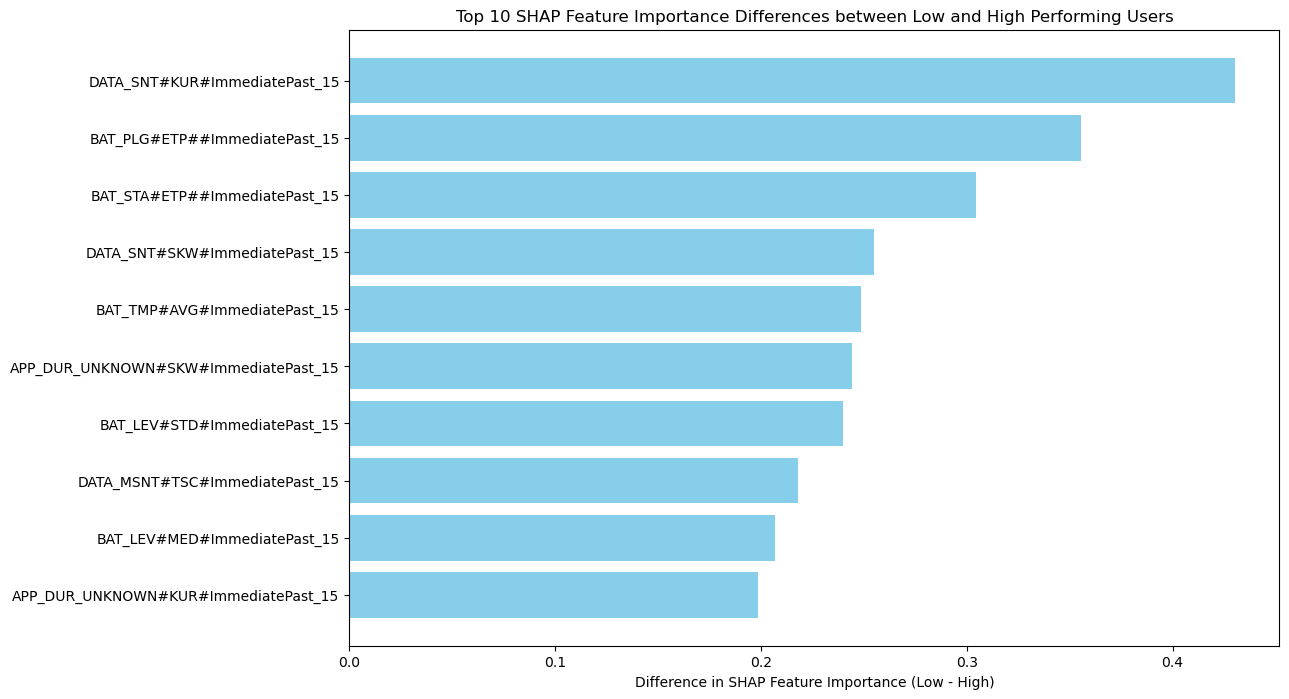

In [35]:
# Plotting
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'][:10], importance_df['Importance_diff'][:10], color='skyblue')
plt.xlabel('Difference in SHAP Feature Importance (Low - High)')
plt.title('Top 10 SHAP Feature Importance Differences between Low and High Performing Users')
plt.gca().invert_yaxis()  # Largest differences on top
plt.show()


In [36]:
# import pandas as pd
# import numpy as np
# import xgboost as xgb
# import matplotlib.pyplot as plt

# # Assuming the sorted_user_auc_df contains the sorted PIDs with their AUC
# lowest_performing_pids = sorted_user_auc_df['PID'].head(5).values

# # Create a DataFrame for the low-performing and high-performing users using the groups array
# X_low = X[np.isin(groups, lowest_performing_pids)]
# X_high = X[~np.isin(groups, lowest_performing_pids)]

# y_low = y[np.isin(groups, lowest_performing_pids)]
# y_high = y[~np.isin(groups, lowest_performing_pids)]

# # Create DMatrix for low and high-performing users
# dtrain_low = xgb.DMatrix(X_low, label=y_low)
# dtrain_high = xgb.DMatrix(X_high, label=y_high)

# # Set up common XGBoost parameters
# params = {
#     'objective': 'binary:logistic',
#     'eval_metric': 'logloss',
#     'eta': 0.1,
#     'max_depth': 6
# }

# # Train the model for low-performing users
# print("Training XGBoost for low-performing users...")
# model_low = xgb.train(params, dtrain_low, num_boost_round=100)

# # Train the model for high-performing users
# print("Training XGBoost for high-performing users...")
# model_high = xgb.train(params, dtrain_high, num_boost_round=100)

# # Get feature importance for both models
# importance_low = model_low.get_score(importance_type='weight')
# importance_high = model_high.get_score(importance_type='weight')

# # Convert the feature importance into a DataFrame for easy comparison
# importance_df_low = pd.DataFrame(list(importance_low.items()), columns=['Feature', 'Importance_low'])
# importance_df_high = pd.DataFrame(list(importance_high.items()), columns=['Feature', 'Importance_high'])

# # Merge both importance DataFrames to compare
# importance_df = pd.merge(importance_df_low, importance_df_high, on='Feature', how='outer').fillna(0)

# # Sort by the difference in importance
# importance_df['Importance_diff'] = importance_df['Importance_low'] - importance_df['Importance_high']
# importance_df = importance_df.sort_values(by='Importance_diff', ascending=False)

# # Display the top features that differ the most
# print("Feature Importance Comparison between Low and High Performing Users:")
# print(importance_df)

# # Plot the feature importance comparison
# plt.figure(figsize=(12, 8))
# plt.barh(importance_df['Feature'], importance_df['Importance_diff'], color='skyblue')
# plt.xlabel('Difference in Feature Importance (Low - High)')
# plt.title('Feature Importance Difference between Low and High Performing Users')
# plt.show()

In [37]:
importance_df = importance_df.sort_values(by='Importance_diff', ascending=True)
importance_df

,Feature,Importance_low,Importance_high,Importance_diff
109,BAT_TMP#MED#ImmediatePast_15,0.265128,0.491781,-0.226653
54,BAT_TMP#VAL,0.106284,0.305111,-0.198827
202,SCR_DUR#TSC#ImmediatePast_15,0.113159,0.260110,-0.146951
104,BAT_TMP#STD#ImmediatePast_15,0.042551,0.188638,-0.146087
92,BAT_LEV#AVG#ImmediatePast_15,0.174976,0.319308,-0.144332
...,...,...,...,...
103,BAT_TMP#AVG#ImmediatePast_15,0.562422,0.313871,0.248550
135,DATA_SNT#SKW#ImmediatePast_15,0.299082,0.044135,0.254947
100,BAT_STA#ETP##ImmediatePast_15,0.311526,0.007225,0.304302
111,BAT_PLG#ETP##ImmediatePast_15,0.375522,0.020142,0.355379


Descriptive Statistics for Low Performing Users:
Mean: 30.113361358642578, Median: 29.399999618530273, Std: 4.905166149139404, Min: 12.899999618530273, Max: 44.900001525878906

Descriptive Statistics for High Performing Users:
Mean: 30.24514389038086, Median: 30.299999237060547, Std: 4.640964031219482, Min: 4.0, Max: 48.599998474121094


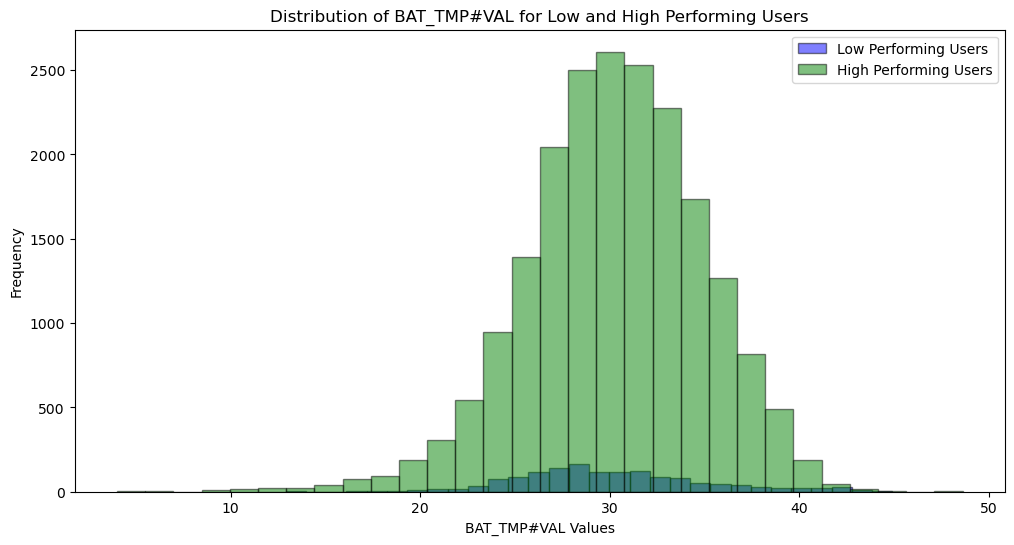

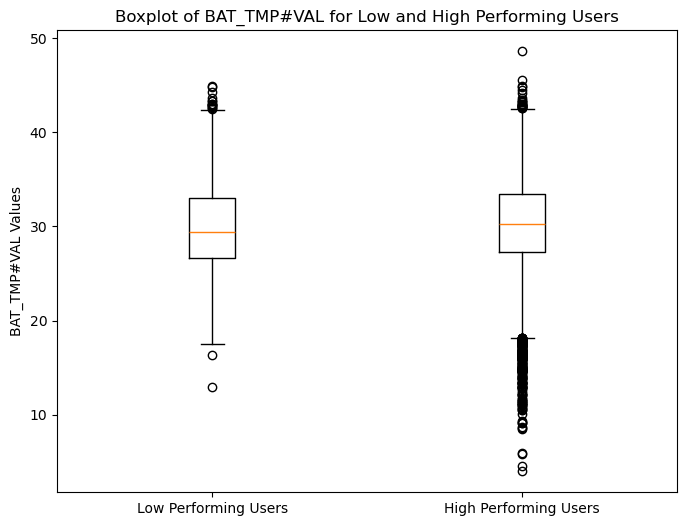

T-test results for BAT_TMP#VAL: t-statistic = -0.9919351757627382, p-value = 0.321375167921001
Mann-Whitney U test results for BAT_TMP#VAL: U-statistic = 13725429.5, p-value = 6.683956332043286e-05
Pearson correlation for low-performing users: -0.07203662212702563
Pearson correlation for high-performing users: -0.2857041503271663


In [38]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'BAT_TMP#VAL'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 11316448.0, Median: 12994.2763671875, Std: 149211872.0, Min: 0.0, Max: 5114170368.0

Descriptive Statistics for High Performing Users:
Mean: 22019194.0, Median: 4020.974609375, Std: 255330128.0, Min: 0.0, Max: 17760813056.0


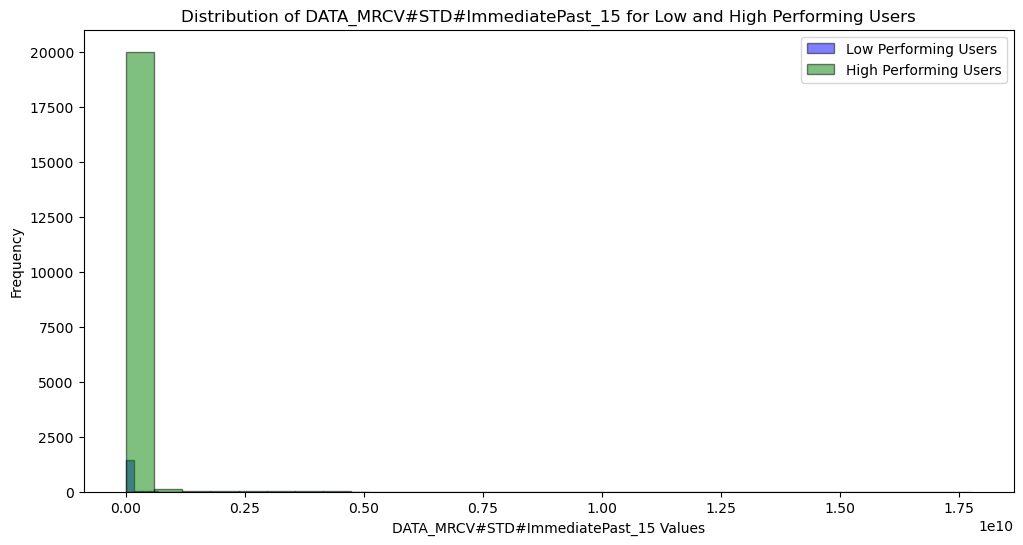

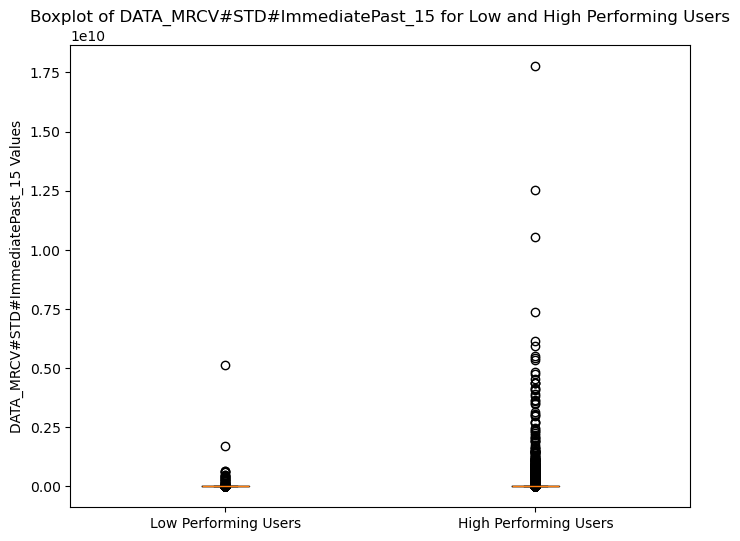

T-test results for DATA_MRCV#STD#ImmediatePast_15: t-statistic = -2.483165106893243, p-value = 0.013098868040335733
Mann-Whitney U test results for DATA_MRCV#STD#ImmediatePast_15: U-statistic = 14353217.0, p-value = 0.20915707099425718
Pearson correlation for low-performing users: 0.0577598133899887
Pearson correlation for high-performing users: 0.04079561883620041


In [39]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'DATA_MRCV#STD#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 769952.0625, Median: 42166.2890625, Std: 4611752.0, Min: 0.0, Max: 78922576.0

Descriptive Statistics for High Performing Users:
Mean: 1916108.875, Median: 2237.465576171875, Std: 15723309.0, Min: 0.0, Max: 1101061632.0


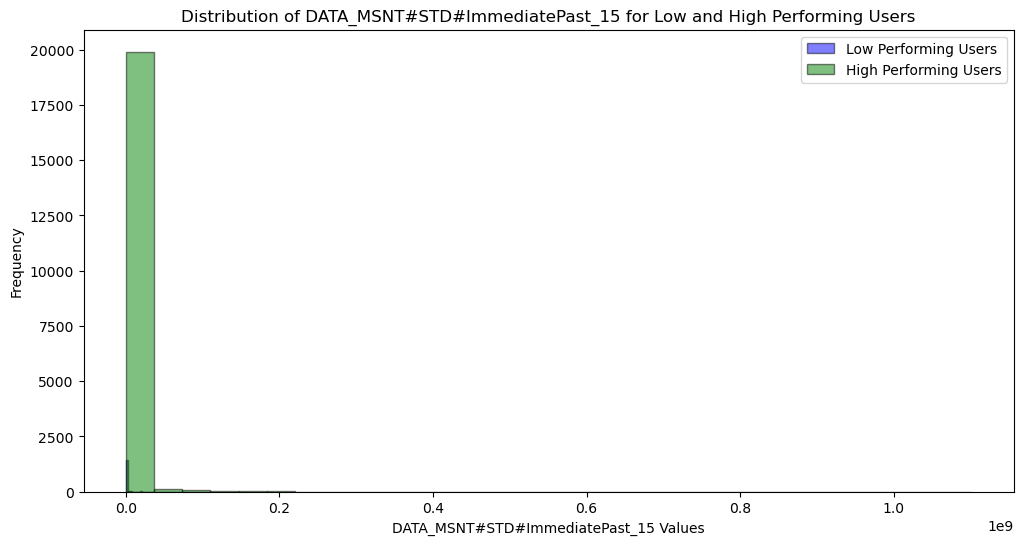

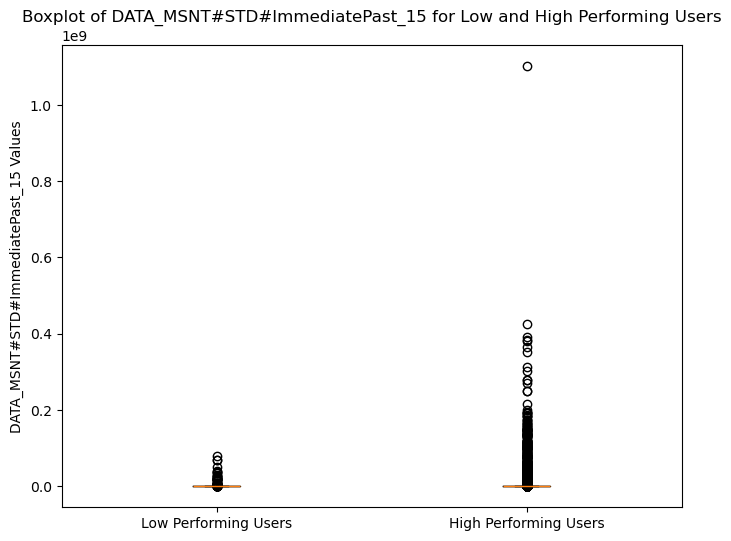

T-test results for DATA_MSNT#STD#ImmediatePast_15: t-statistic = -6.985867638533562, p-value = 3.23073134766842e-12
Mann-Whitney U test results for DATA_MSNT#STD#ImmediatePast_15: U-statistic = 14874651.5, p-value = 0.30883273139836875
Pearson correlation for low-performing users: 0.0629936512227066
Pearson correlation for high-performing users: 0.05649964863345317


In [40]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'DATA_MSNT#STD#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


In [41]:
importance_df.head(20)

,Feature,Importance_low,Importance_high,Importance_diff
109,BAT_TMP#MED#ImmediatePast_15,0.265128,0.491781,-0.226653
54,BAT_TMP#VAL,0.106284,0.305111,-0.198827
202,SCR_DUR#TSC#ImmediatePast_15,0.113159,0.260110,-0.146951
104,BAT_TMP#STD#ImmediatePast_15,0.042551,0.188638,-0.146087
92,BAT_LEV#AVG#ImmediatePast_15,0.174976,0.319308,-0.144332
146,DATA_MRCV#BEP#ImmediatePast_15,0.032042,0.157784,-0.125742
52,BAT_LEV#VAL,0.267652,0.389881,-0.122229
119,CALL_DUR#BEP#ImmediatePast_15,0.000000,0.107616,-0.107616
148,DATA_MRCV#TSC#ImmediatePast_15,0.189751,0.287529,-0.097778
152,DATA_MSNT#KUR#ImmediatePast_15,0.059630,0.153103,-0.093473


Descriptive Statistics for Low Performing Users:
Mean: 2.393267869949341, Median: 2.2439703941345215, Std: 1.8121709823608398, Min: 0.0, Max: 12.754207611083984

Descriptive Statistics for High Performing Users:
Mean: 2.5529472827911377, Median: 2.3386988639831543, Std: 1.8072352409362793, Min: 0.0, Max: 18.208240509033203


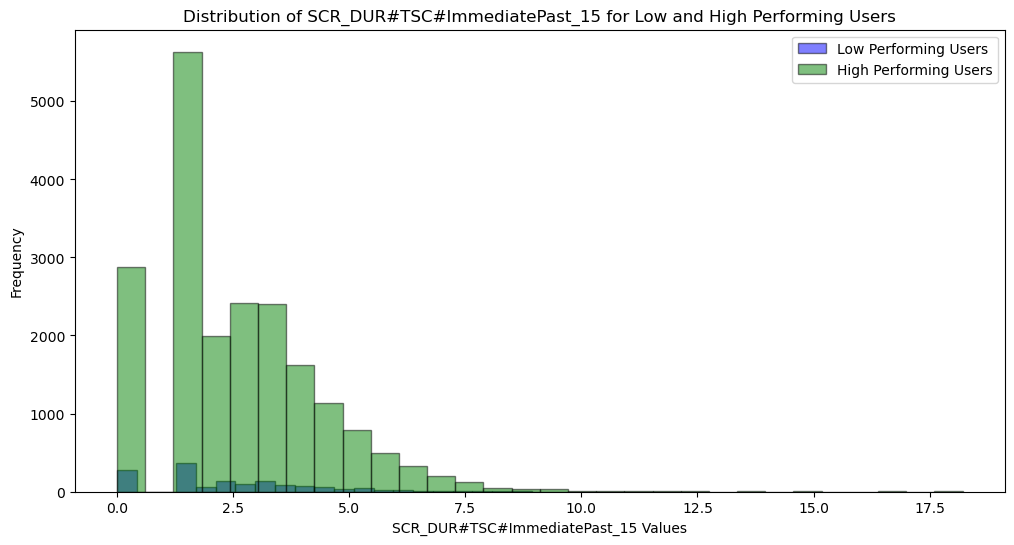

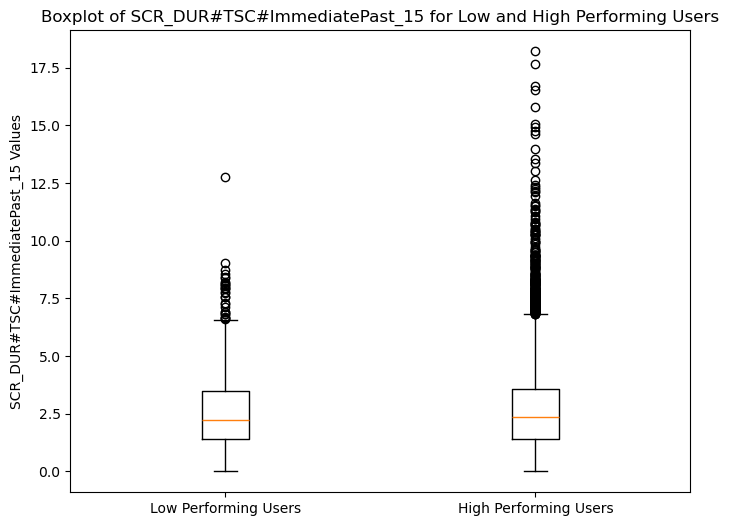

T-test results for SCR_DUR#TSC#ImmediatePast_15: t-statistic = -3.242452990484181, p-value = 0.0012084941452203913
Mann-Whitney U test results for SCR_DUR#TSC#ImmediatePast_15: U-statistic = 13858800.0, p-value = 0.000638050201882855
Pearson correlation for low-performing users: 0.17173919731407947
Pearson correlation for high-performing users: 0.2838584668066807


In [42]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'SCR_DUR#TSC#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 11316448.0, Median: 12994.2763671875, Std: 149211872.0, Min: 0.0, Max: 5114170368.0

Descriptive Statistics for High Performing Users:
Mean: 22019194.0, Median: 4020.974609375, Std: 255330128.0, Min: 0.0, Max: 17760813056.0


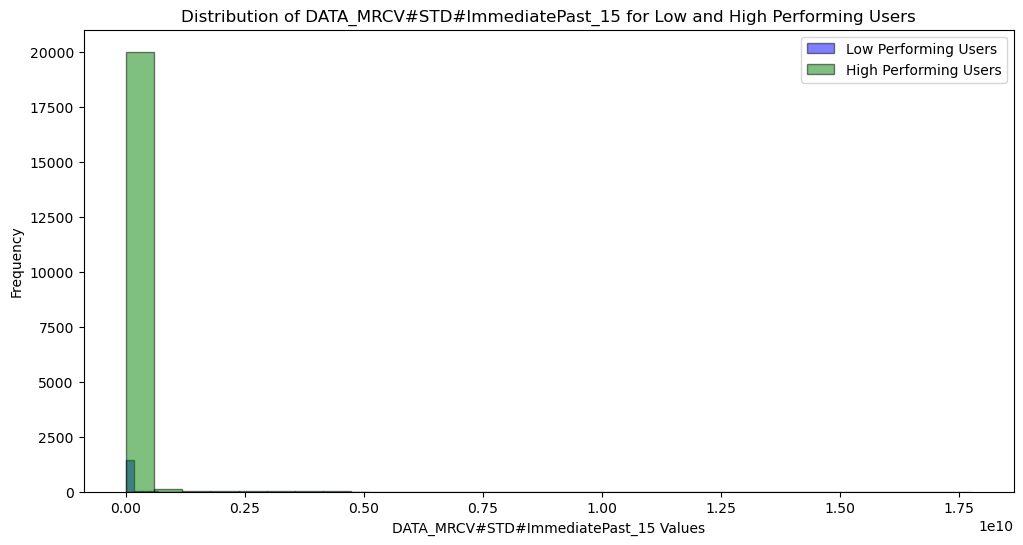

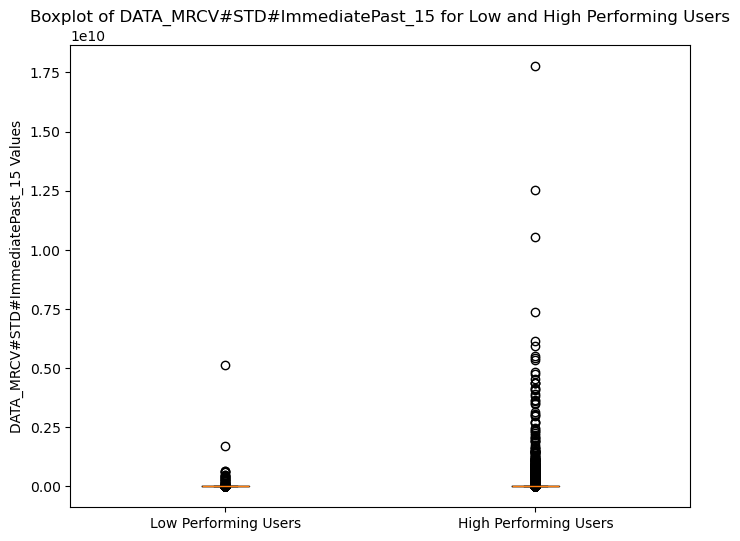

T-test results for DATA_MRCV#STD#ImmediatePast_15: t-statistic = -2.483165106893243, p-value = 0.013098868040335733
Mann-Whitney U test results for DATA_MRCV#STD#ImmediatePast_15: U-statistic = 14353217.0, p-value = 0.20915707099425718
Pearson correlation for low-performing users: 0.0577598133899887
Pearson correlation for high-performing users: 0.04079561883620041


In [43]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'DATA_MRCV#STD#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 769952.0625, Median: 42166.2890625, Std: 4611752.0, Min: 0.0, Max: 78922576.0

Descriptive Statistics for High Performing Users:
Mean: 1916108.875, Median: 2237.465576171875, Std: 15723309.0, Min: 0.0, Max: 1101061632.0


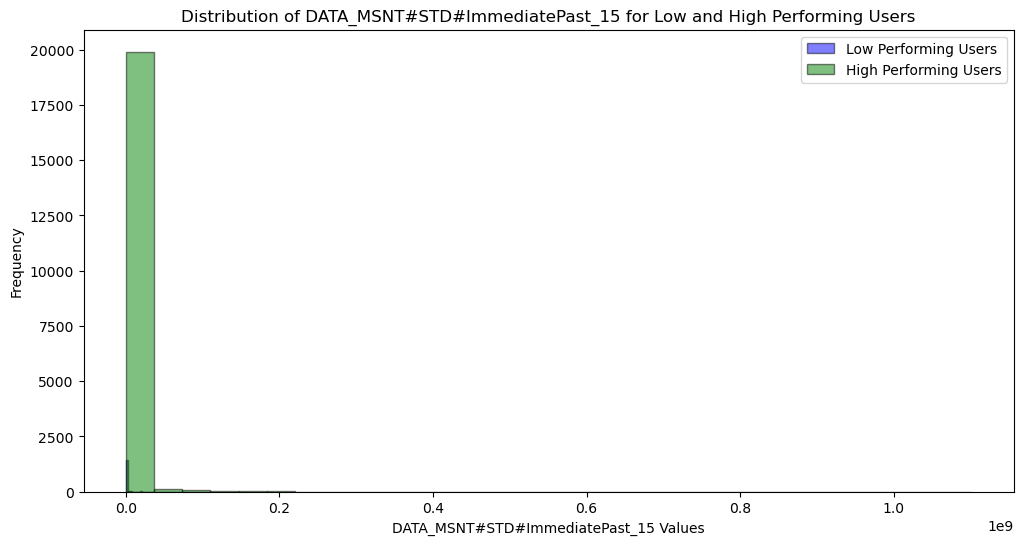

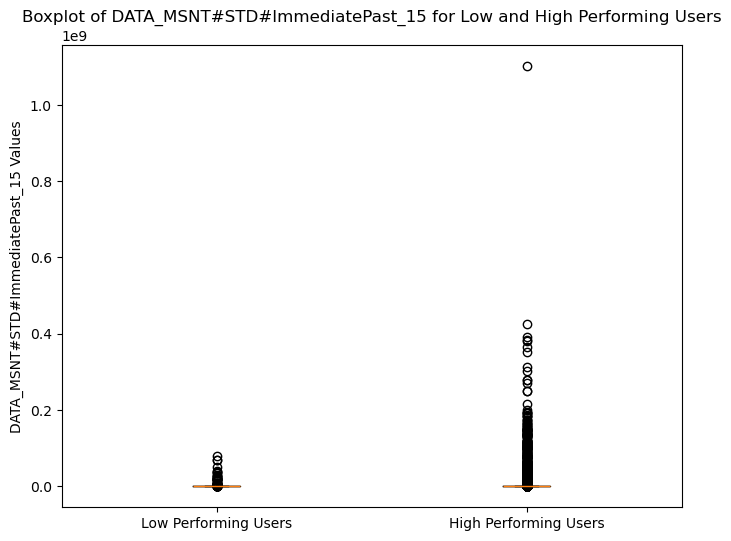

T-test results for DATA_MSNT#STD#ImmediatePast_15: t-statistic = -6.985867638533562, p-value = 3.23073134766842e-12
Mann-Whitney U test results for DATA_MSNT#STD#ImmediatePast_15: U-statistic = 14874651.5, p-value = 0.30883273139836875
Pearson correlation for low-performing users: 0.0629936512227066
Pearson correlation for high-performing users: 0.05649964863345317


In [44]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'DATA_MSNT#STD#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 29.441804885864258, Median: 29.200000762939453, Std: 6.118747711181641, Min: 0.0, Max: 44.70000076293945

Descriptive Statistics for High Performing Users:
Mean: 29.48502540588379, Median: 30.049999237060547, Std: 6.403238296508789, Min: 0.0, Max: 48.79999923706055


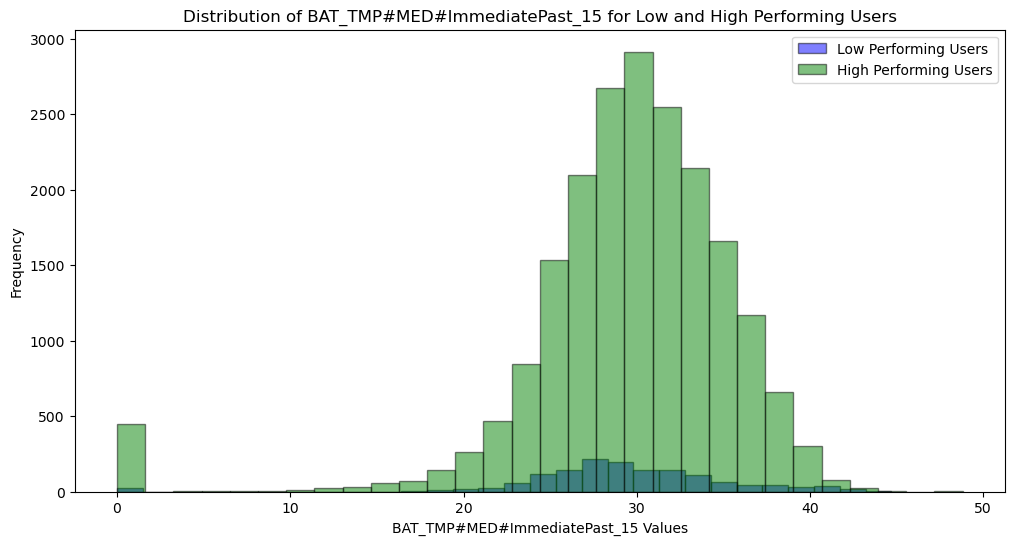

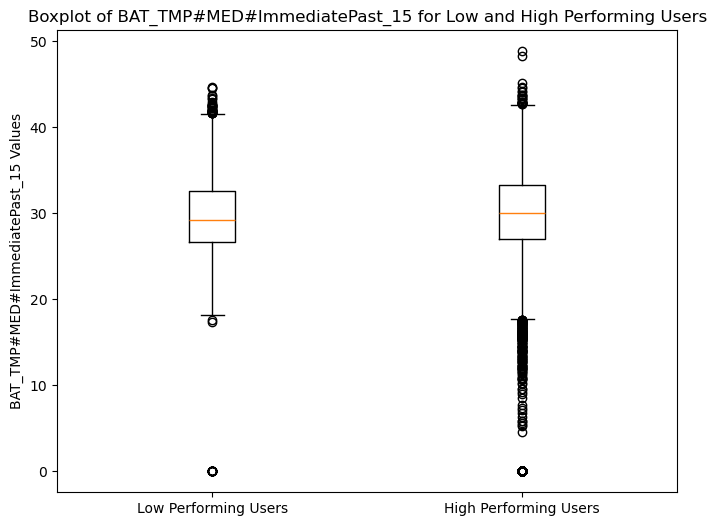

T-test results for BAT_TMP#MED#ImmediatePast_15: t-statistic = -0.2590542306055247, p-value = 0.7956249860063679
Mann-Whitney U test results for BAT_TMP#MED#ImmediatePast_15: U-statistic = 13702162.5, p-value = 4.341131296027802e-05
Pearson correlation for low-performing users: -0.07238358349179089
Pearson correlation for high-performing users: -0.15408201916326109


In [45]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'BAT_TMP#MED#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 1804.082275390625, Median: 1378.58154296875, Std: 3598.85498046875, Min: 0.0, Max: 66975.1328125

Descriptive Statistics for High Performing Users:
Mean: 1592.2181396484375, Median: 1366.9520263671875, Std: 1994.433349609375, Min: 0.0, Max: 44371.80859375


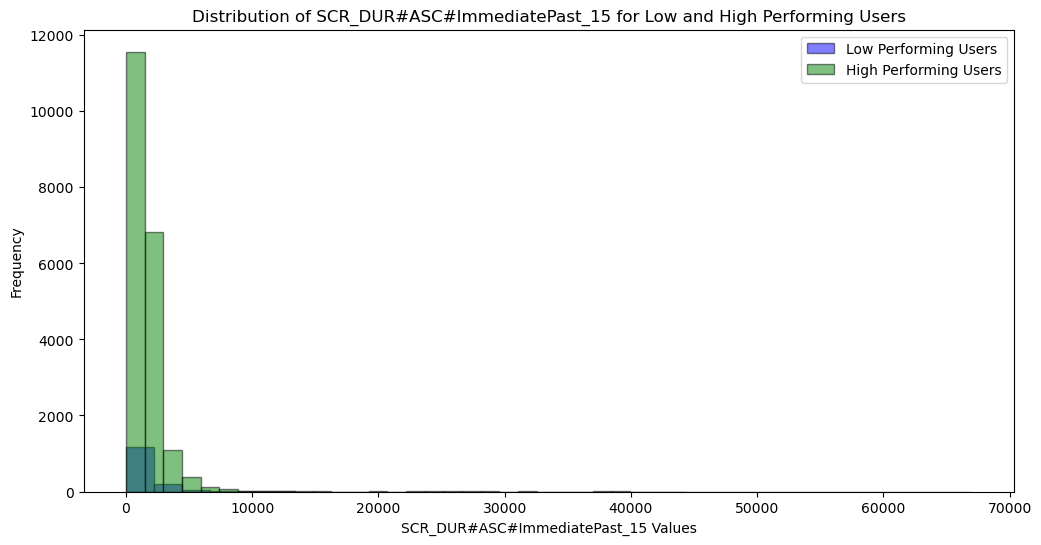

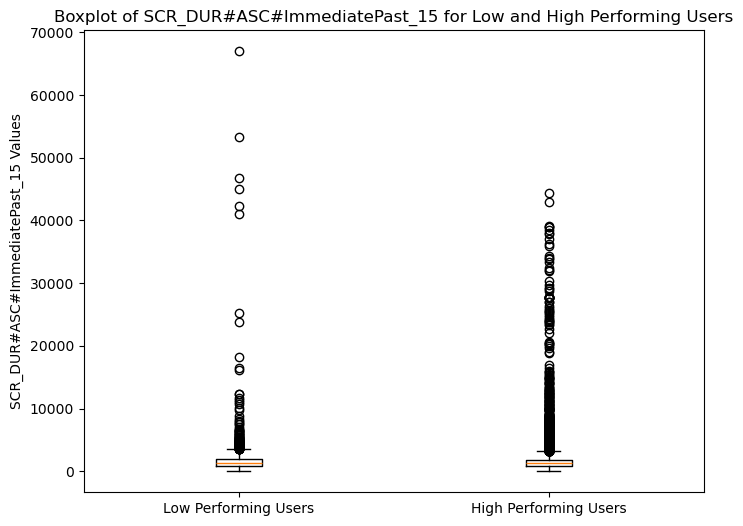

T-test results for SCR_DUR#ASC#ImmediatePast_15: t-statistic = 2.218093583853004, p-value = 0.026696196532561223
Mann-Whitney U test results for SCR_DUR#ASC#ImmediatePast_15: U-statistic = 14678367.0, p-value = 0.8714008389204776
Pearson correlation for low-performing users: 0.010358881622070963
Pearson correlation for high-performing users: -0.026926827551158796


In [46]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'SCR_DUR#ASC#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")

Descriptive Statistics for Low Performing Users:
Mean: 3422.644287109375, Median: 49.339500427246094, Std: 13372.693359375, Min: 1.1269999742507935, Max: 119310.765625

Descriptive Statistics for High Performing Users:
Mean: 533.9127197265625, Median: 48.76599884033203, Std: 1609.8531494140625, Min: 1.8350000381469727, Max: 44205.43359375


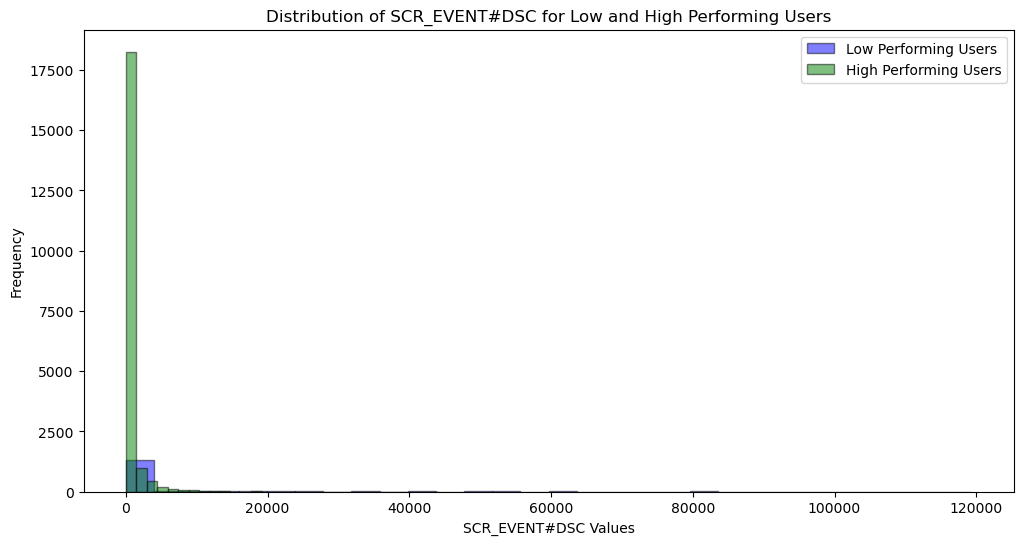

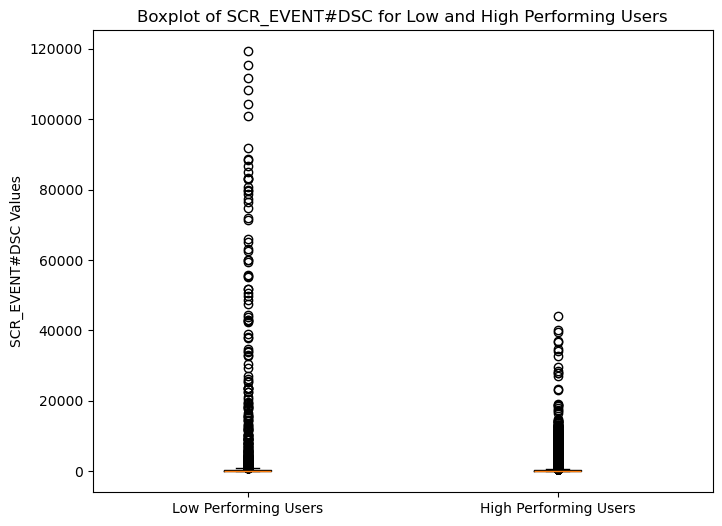

T-test results for SCR_EVENT#DSC: t-statistic = 8.224242126369973, p-value = 4.309113588518903e-16
Mann-Whitney U test results for SCR_EVENT#DSC: U-statistic = 14889493.5, p-value = 0.27978111496148983
Pearson correlation for low-performing users: -0.0662003706592116
Pearson correlation for high-performing users: -0.12159254074155015


In [47]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'SCR_EVENT#DSC'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")

Descriptive Statistics for Low Performing Users:
Mean: 6.715564727783203, Median: 4.0, Std: 8.461379051208496, Min: 0.0, Max: 79.0

Descriptive Statistics for High Performing Users:
Mean: 11.266871452331543, Median: 4.0, Std: 79.59847259521484, Min: 0.0, Max: 3122.0


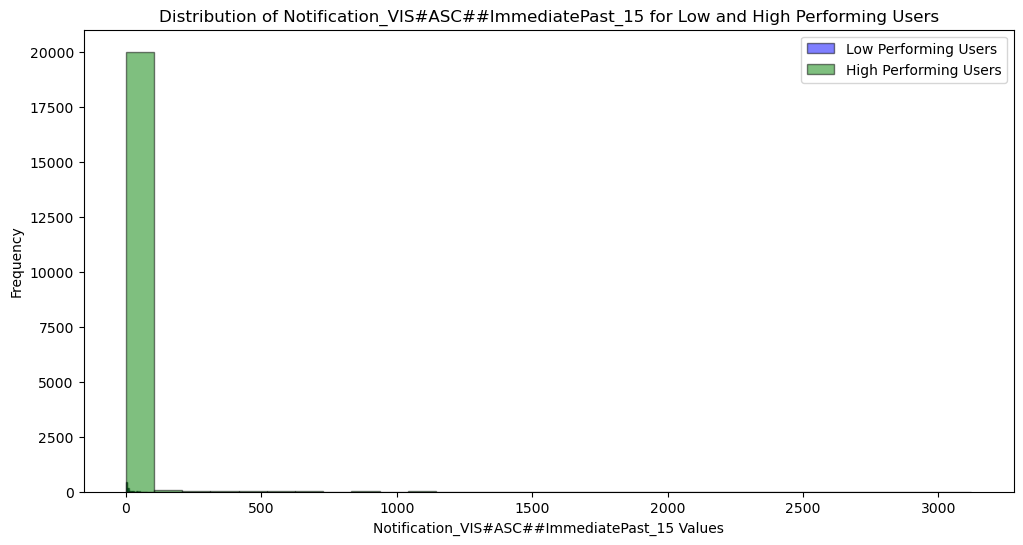

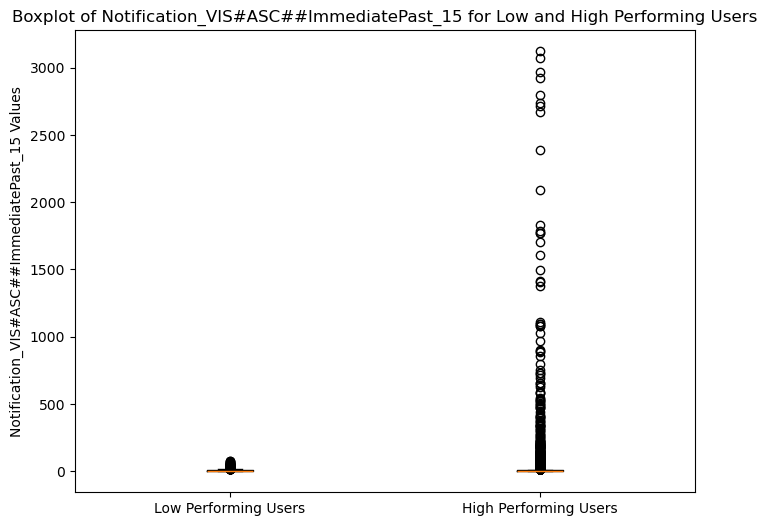

T-test results for Notification_VIS#ASC##ImmediatePast_15: t-statistic = -7.5488828476849, p-value = 4.577046891576858e-14
Mann-Whitney U test results for Notification_VIS#ASC##ImmediatePast_15: U-statistic = 13622428.5, p-value = 8.102790502890284e-06
Pearson correlation for low-performing users: 0.059235724539618013
Pearson correlation for high-performing users: 0.053423844056414906


In [48]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'Notification_VIS#ASC##ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")